## Task 1

In [84]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

# Set style for better notebook visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [85]:
# Data loading and preprocessing functions
def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    """
    Load and preprocess the match data.

    Args:
        file_path: Path to the match data file

    Returns:
        Preprocessed DataFrame
    """
    # Load the data
    df = pd.read_csv(file_path)

    # Filter out rows where odds are suspended or stopped
    df = df[~(df['suspended'] | df['stopped'])]

    # Convert odds columns to numeric, handling any errors
    odds_columns = ['1', 'X', '2']
    df[odds_columns] = df[odds_columns].apply(pd.to_numeric, errors='coerce')

    # Display basic information about the dataset
    print("Dataset Overview:")
    print("-" * 50)
    print(f"Total number of rows: {len(df)}")
    print(f"Number of unique matches: {df['fixture_id'].nunique()}")
    print("\nSample of the data:")
    display(df.head())

    return df

In [86]:
# Probability calculation functions
def calculate_probabilities(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate raw and normalized probabilities from odds.

    Args:
        df: Input DataFrame with odds columns

    Returns:
        DataFrame with added probability columns
    """
    # Calculate raw probabilities (1/odds)
    df['p_home_raw'] = 1 / df['1']
    df['p_draw_raw'] = 1 / df['X']
    df['p_away_raw'] = 1 / df['2']

    # Calculate sum for normalization
    prob_sum = df['p_home_raw'] + df['p_draw_raw'] + df['p_away_raw']

    # Calculate normalized probabilities
    df['p_home'] = df['p_home_raw'] / prob_sum
    df['p_draw'] = df['p_draw_raw'] / prob_sum
    df['p_away'] = df['p_away_raw'] / prob_sum

    # Display probability statistics
    print("Probability Statistics:")
    print("-" * 50)
    prob_cols = ['p_home', 'p_draw', 'p_away']
    display(df[prob_cols].describe())

    return df


In [87]:
# Probability binning functions
def create_probability_bins(df: pd.DataFrame, half: str) -> Tuple[pd.DataFrame, List[float]]:
    """
    Create probability bins and calculate actual draw probabilities for each bin.

    Args:
        df: DataFrame with probability columns
        half: String indicating which half ('1st-half' or '2nd-half')

    Returns:
        DataFrame with binned probabilities and bin edges
    """
    # Filter data for specific half
    half_data = df[df['halftime'] == half].copy()

    # Calculate P(home win) - P(away win)
    half_data['p_diff'] = half_data['p_home'] - half_data['p_away']

    # Create bins for P(home win) - P(away win)
    bins = np.linspace(-1, 1, 11)  # Creates 10 bins from -1 to 1
    half_data['p_diff_bin'] = pd.cut(half_data['p_diff'], bins)

    # Calculate actual draw probability for each bin
    bin_stats = half_data.groupby('p_diff_bin').agg({
        'p_draw': 'mean',
        'result': lambda x: (x == 'X').mean(),
        'fixture_id': 'count'
    }).rename(columns={
        'p_draw': 'bookmaker_draw_prob',
        'result': 'actual_draw_prob',
        'fixture_id': 'match_count'
    })

    return bin_stats, bins

In [88]:
# Plotting functions
def plot_probabilities(bin_stats: pd.DataFrame, bins: List[float], half: str):
    """
    Create probability comparison plot.

    Args:
        bin_stats: DataFrame with binned statistics
        bins: List of bin edges
        half: String indicating which half
    """
    plt.figure(figsize=(15, 10))

    # Calculate midpoints of the bins
    bin_midpoints = [(interval.left + interval.right) / 2 for interval in bin_stats.index.categories]

    # Plot bookmaker probabilities using bin_midpoints
    plt.plot(bin_midpoints, bin_stats['bookmaker_draw_prob'],
             'b-', label='Bookmaker Draw Probability', marker='o', markersize=10)

    # Plot actual probabilities using bin_midpoints
    plt.plot(bin_midpoints, bin_stats['actual_draw_prob'],
             'r--', label='Actual Draw Probability', marker='s', markersize=10)
    # Customize plot
    plt.title(f'Draw Probabilities Comparison - {half}', fontsize=16, pad=20)
    plt.xlabel('P(home win) - P(away win)', fontsize=12)
    plt.ylabel('P(draw)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Add match counts as annotations
    for i, (idx, row) in enumerate(bin_stats.iterrows()):
        plt.annotate(f'n={int(row["match_count"])}',
                    xy=(idx.mid, row['bookmaker_draw_prob']),
                    xytext=(0, 10), textcoords='offset points',
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()

In [89]:
# Analysis function
def analyze_odds_bias(df: pd.DataFrame):
    """
    Perform complete odds bias analysis for both halves.

    Args:
        df: Input DataFrame with match data
    """
    results = {}

    # Process data for each half
    for half in ['1st-half', '2nd-half']:
        # Calculate binned statistics
        bin_stats, bins = create_probability_bins(df, half)

        # Store results
        results[half] = {
            'bin_stats': bin_stats,
            'bins': bins
        }

        # Create visualization
        plot_probabilities(bin_stats, bins, half)

        # Print analysis
        print(f"\nBias Analysis for {half}:")
        print("=" * 50)
        print("\nBin Statistics:")
        display(bin_stats)

        # Calculate and display overall bias metrics
        avg_bookmaker_prob = bin_stats['bookmaker_draw_prob'].mean()
        avg_actual_prob = bin_stats['actual_draw_prob'].mean()

        print(f"\nOverall Metrics:")
        print(f"Average Bookmaker Draw Probability: {avg_bookmaker_prob:.3f}")
        print(f"Average Actual Draw Probability: {avg_actual_prob:.3f}")
        print(f"Overall Bias: {avg_bookmaker_prob - avg_actual_prob:.3f}")

    return results

In [90]:
# Margin Analysis
def analyze_bookmaker_margin(df: pd.DataFrame):
    """
    Analyze the bookmaker's margin across different scenarios.
    """
    print("Bookmaker's Margin Analysis")
    print("=" * 50)

    # Calculate margin for each row
    df['margin'] = (1/df['1'] + 1/df['X'] + 1/df['2'] - 1) * 100

    # Overall margin statistics
    print("\nOverall Margin Statistics:")
    print(df['margin'].describe())

    # Margin by half
    print("\nAverage Margin by Half:")
    print(df.groupby('halftime')['margin'].mean())

    # Visualize margin distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='margin', hue='halftime', bins=50)
    plt.title('Distribution of Bookmaker Margins')
    plt.xlabel('Margin (%)')
    plt.ylabel('Count')
    plt.show()

In [91]:
# Draw Probability Analysis
def analyze_draw_probabilities(df: pd.DataFrame):
    """
    Detailed analysis of draw probabilities.
    """
    print("Draw Probability Analysis")
    print("=" * 50)

    # Calculate implied draw probabilities
    df['implied_draw_prob'] = df['p_draw'] * 100

    # Draw probability statistics
    print("\nImplied Draw Probability Statistics:")
    print(df.groupby('halftime')['implied_draw_prob'].describe())

    # Visualize draw probability distribution
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='halftime', y='implied_draw_prob')
    plt.title('Distribution of Implied Draw Probabilities by Half')
    plt.xlabel('Half')
    plt.ylabel('Implied Draw Probability (%)')
    plt.show()

In [92]:
# Calibration Analysis
def analyze_probability_calibration(df: pd.DataFrame):
    """
    Analyze how well calibrated the bookmaker probabilities are.
    """
    print("Probability Calibration Analysis")
    print("=" * 50)

    def calculate_calibration_stats(data, prob_col, result_val):
        # Create 10 probability bins
        data['prob_bin'] = pd.qcut(data[prob_col], q=10, labels=False)

        # Calculate calibration statistics
        cal_stats = data.groupby('prob_bin').agg({
            prob_col: 'mean',
            'result': lambda x: (x == result_val).mean(),
            'fixture_id': 'count'
        }).reset_index()

        cal_stats.columns = ['bin', 'predicted_prob', 'actual_prob', 'count']
        return cal_stats

    # Calculate calibration stats for draws
    for half in ['1st-half', '2nd-half']:
        half_data = df[df['halftime'] == half].copy()
        cal_stats = calculate_calibration_stats(half_data, 'p_draw', 'X')

        print(f"\nCalibration Statistics for {half}:")
        display(cal_stats)

        # Plot calibration curve
        plt.figure(figsize=(10, 10))
        plt.plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
        plt.scatter(cal_stats['predicted_prob'], cal_stats['actual_prob'],
                   s=cal_stats['count']/10, alpha=0.6)

        # Add count labels
        for _, row in cal_stats.iterrows():
            plt.annotate(f'n={row["count"]}',
                        (row['predicted_prob'], row['actual_prob']),
                        xytext=(5, 5), textcoords='offset points')

        plt.title(f'Probability Calibration Curve - {half}')
        plt.xlabel('Predicted Draw Probability')
        plt.ylabel('Actual Draw Probability')
        plt.grid(True)
        plt.legend()
        plt.show()

In [93]:
# Market Efficiency Analysis
def analyze_market_efficiency(df: pd.DataFrame):
    """
    Analyze the efficiency of the betting market.
    """
    print("Market Efficiency Analysis")
    print("=" * 50)

    # Calculate average deviation between predicted and actual probabilities
    df['draw_prob_error'] = abs(df['p_draw'] - (df['result'] == 'X').astype(float))

    # Analyze errors by half
    print("\nAverage Probability Error by Half:")
    print(df.groupby('halftime')['draw_prob_error'].mean())

    # Calculate Brier score (measure of probability prediction accuracy)
    df['brier_score'] = (df['p_draw'] - (df['result'] == 'X').astype(float))**2

    print("\nBrier Score by Half:")
    print(df.groupby('halftime')['brier_score'].mean())

    # Visualize prediction errors
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='halftime', y='draw_prob_error')
    plt.title('Distribution of Prediction Errors by Half')
    plt.xlabel('Half')
    plt.ylabel('Absolute Prediction Error')
    plt.show()

In [94]:
# Load the data
df = load_and_preprocess_data('match_data')

# Calculate probabilities
df = calculate_probabilities(df)

Dataset Overview:
--------------------------------------------------
Total number of rows: 56127
Number of unique matches: 648

Sample of the data:


,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,suspended,stopped,1,2,X,name,ticking,Accurate Crosses - away,Accurate Crosses - home,Assists - away,Assists - home,Attacks - away,Attacks - home,Ball Possession % - away,Ball Possession % - home,Ball Safe - away,Ball Safe - home,Challenges - away,Challenges - home,Corners - away,Corners - home,Counter Attacks - away,Counter Attacks - home,Dangerous Attacks - away,Dangerous Attacks - home,Dribble Attempts - away,Dribble Attempts - home,Fouls - away,Fouls - home,Free Kicks - away,Free Kicks - home,Goal Attempts - away,Goal Attempts - home,Goal Kicks - away,Goal Kicks - home,Goals - away,Goals - home,Headers - away,Headers - home,Hit Woodwork - away,Hit Woodwork - home,Injuries - away,Injuries - home,Interceptions - away,Interceptions - home,Key Passes - away,Key Passes - home,Long Passes - away,Long Passes - home,Offsides - away,Offsides - home,Passes - away,Passes - home,Penalties - away,Penalties - home,Redcards - away,Redcards - home,Saves - away,Saves - home,Score Change - away,Score Change - home,Shots Blocked - away,Shots Blocked - home,Shots Insidebox - away,Shots Insidebox - home,Shots Off Target - away,Shots Off Target - home,Shots On Target - away,Shots On Target - home,Shots Outsidebox - away,Shots Outsidebox - home,Shots Total - away,Shots Total - home,Substitutions - away,Substitutions - home,Successful Dribbles - away,Successful Dribbles - home,Successful Headers - away,Successful Headers - home,Successful Interceptions - away,Successful Interceptions - home,Successful Passes - away,Successful Passes - home,Successful Passes Percentage - away,Successful Passes Percentage - home,Tackles - away,Tackles - home,Throwins - away,Throwins - home,Total Crosses - away,Total Crosses - home,Yellowcards - away,Yellowcards - home,Yellowred Cards - away,Yellowred Cards - home,current_state,final_score,result
0,19172016.0,1st-half,2024-08-09 18:11:36,2024-08-09 18:01:37,2024-08-09 18:01:37,9,59,2024-08-09 18:11:28,False,False,1.22,10.0,6.5,Galatasaray vs Hatayspor,True,0.0,0.0,NaN,NaN,2.0,18.0,28.0,72.0,9.0,7.0,1.0,1.0,0.0,0.0,NaN,NaN,0.0,9.0,1.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,24.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,NaN,NaN,1.0,1.0,14.0,55.0,58.0,91.0,3.0,1.0,3.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,X,2-1,1
1,19172016.0,1st-half,2024-08-09 18:27:30,2024-08-09 18:01:37,2024-08-09 18:01:37,25,53,2024-08-09 18:27:24,False,False,1.20,13.0,6.0,Galatasaray vs Hatayspor,True,0.0,1.0,NaN,NaN,12.0,40.0,24.0,76.0,9.0,7.0,2.0,2.0,1.0,4.0,NaN,NaN,5.0,29.0,3.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,2.0,2.0,0.0,2.0,NaN,NaN,1.0,1.0,38.0,116.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,5.0,0.0,0.0,1.0,3.0,NaN,NaN,2.0,2.0,20.0,101.0,52.0,87.0,8.0,5.0,6.0,11.0,1.0,12.0,0.0,0.0,0.0,0.0,X,2-1,1
2,19172016.0,1st-half,2024-08-09 18:28:25,2024-08-09 18:01:37,2024-08-09 18:01:37,26,48,2024-08-09 18:28:20,False,False,1.20,13.0,6.0,Galatasaray vs Hatayspor,True,0.0,1.0,NaN,NaN,12.0,40.0,21.0,79.0,9.0,7.0,2.0,2.0,1.0,4.0,NaN,NaN,5.0,29.0,3.0,6.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,2.0,2.0,0.0,2.0,NaN,NaN,1.0,1.0,40.0,145.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,5.0,0.0,0.0,1.0,3.0,NaN,NaN,2.0,2.0,20.0,128.0,50.0,88.0,10.0,5.0,6.0,11.0,1.0,13.0,0.0,0.0,0.0,0.0,X,2-1,1
3,19172016.0,1st-half,2024-08-09 18:29:32,2024-08-09 18:01:37,2024-08-09 18:01:37,27,55,2024-08-09 18:29:28,False,False,1.20,13.0,6.0,Galatasaray vs Hatayspor,True,0.0,1.0,NaN,NaN,12.0,42.0,22.0,78.0,9.0,7.0,2.0,2.0,1.0,4.0,NaN,NaN,5.0,32.0,3.0,6.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,2.0,3.0,0.0,2.0,NaN,NaN,1.0,1.0,45.0,153.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,5.0,0.

Probability Statistics:
--------------------------------------------------


,p_home,p_draw,p_away
count,56127.000000,56127.000000,56127.000000
mean,0.423320,0.264879,0.311801
std,0.292370,0.162649,0.273409
min,0.001901,0.019082,0.001917
25%,0.185153,0.156172,0.085360
50%,0.375000,0.257802,0.235763
75%,0.675036,0.325330,0.466463
max,0.978853,0.944444,0.978853



Bias Analysis for 1st-half:

Bin Statistics:


,bookmaker_draw_prob,actual_draw_prob,match_count
p_diff_bin,,,
"(-1.0, -0.8]",0.070634,0.061747,664
"(-0.8, -0.6]",0.161599,0.158094,1322
"(-0.6, -0.4]",0.233996,0.253499,1929
"(-0.4, -0.2]",0.280470,0.276903,3048
"(-0.2, 0.0]",0.310683,0.281617,4428
"(0.0, 0.2]",0.316897,0.371001,5407
"(0.2, 0.4]",0.285142,0.337669,4152
"(0.4, 0.6]",0.233965,0.243847,3494
"(0.6, 0.8]",0.160991,0.132561,3108



Overall Metrics:
Average Bookmaker Draw Probability: 0.212
Average Actual Draw Probability: 0.219
Overall Bias: -0.006

Bias Analysis for 2nd-half:

Bin Statistics:


,bookmaker_draw_prob,actual_draw_prob,match_count
p_diff_bin,,,
"(-1.0, -0.8]",0.073493,0.083615,3552
"(-0.8, -0.6]",0.196147,0.212757,2289
"(-0.6, -0.4]",0.277857,0.359580,1143
"(-0.4, -0.2]",0.397355,0.435714,1120
"(-0.2, 0.0]",0.550723,0.550248,2826
"(0.0, 0.2]",0.573570,0.602127,4044
"(0.2, 0.4]",0.430852,0.394048,1949
"(0.4, 0.6]",0.292296,0.232194,1404
"(0.6, 0.8]",0.193143,0.223951,2956



Overall Metrics:
Average Bookmaker Draw Probability: 0.306
Average Actual Draw Probability: 0.315
Overall Bias: -0.009
Bookmaker's Margin Analysis

Overall Margin Statistics:
count    56127.000000
mean         6.304518
std          1.081244
min          2.160385
25%          5.775401
50%          6.428022
75%          7.017544
max          9.610390
Name: margin, dtype: float64

Average Margin by Half:
halftime
1st-half    6.444166
2nd-half    6.153643
Name: margin, dtype: float64


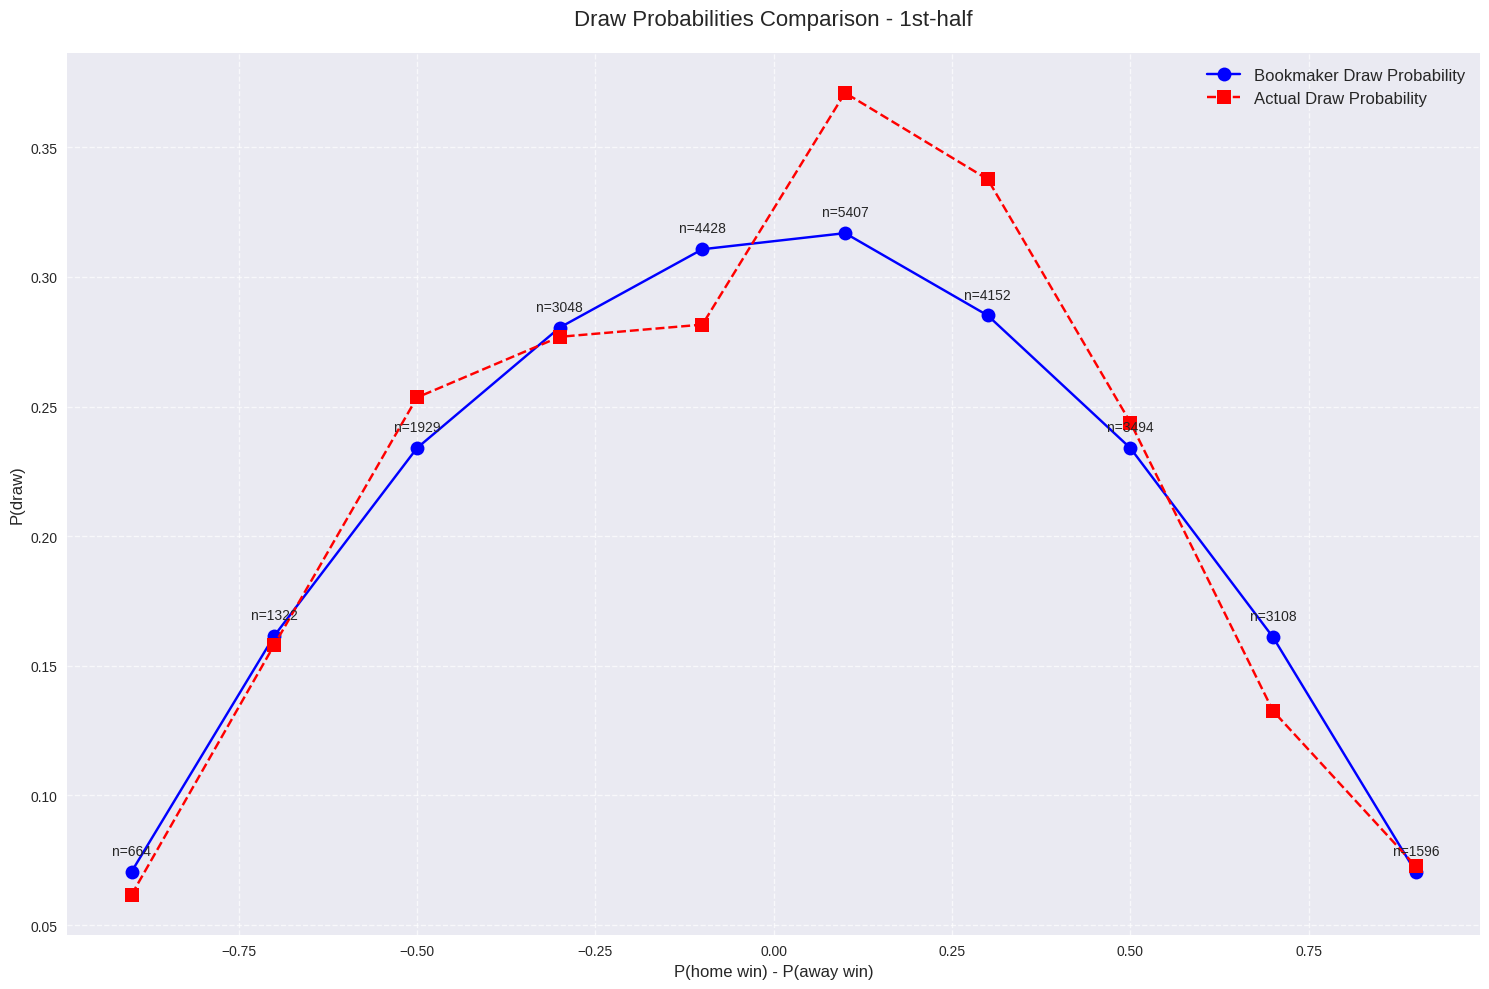

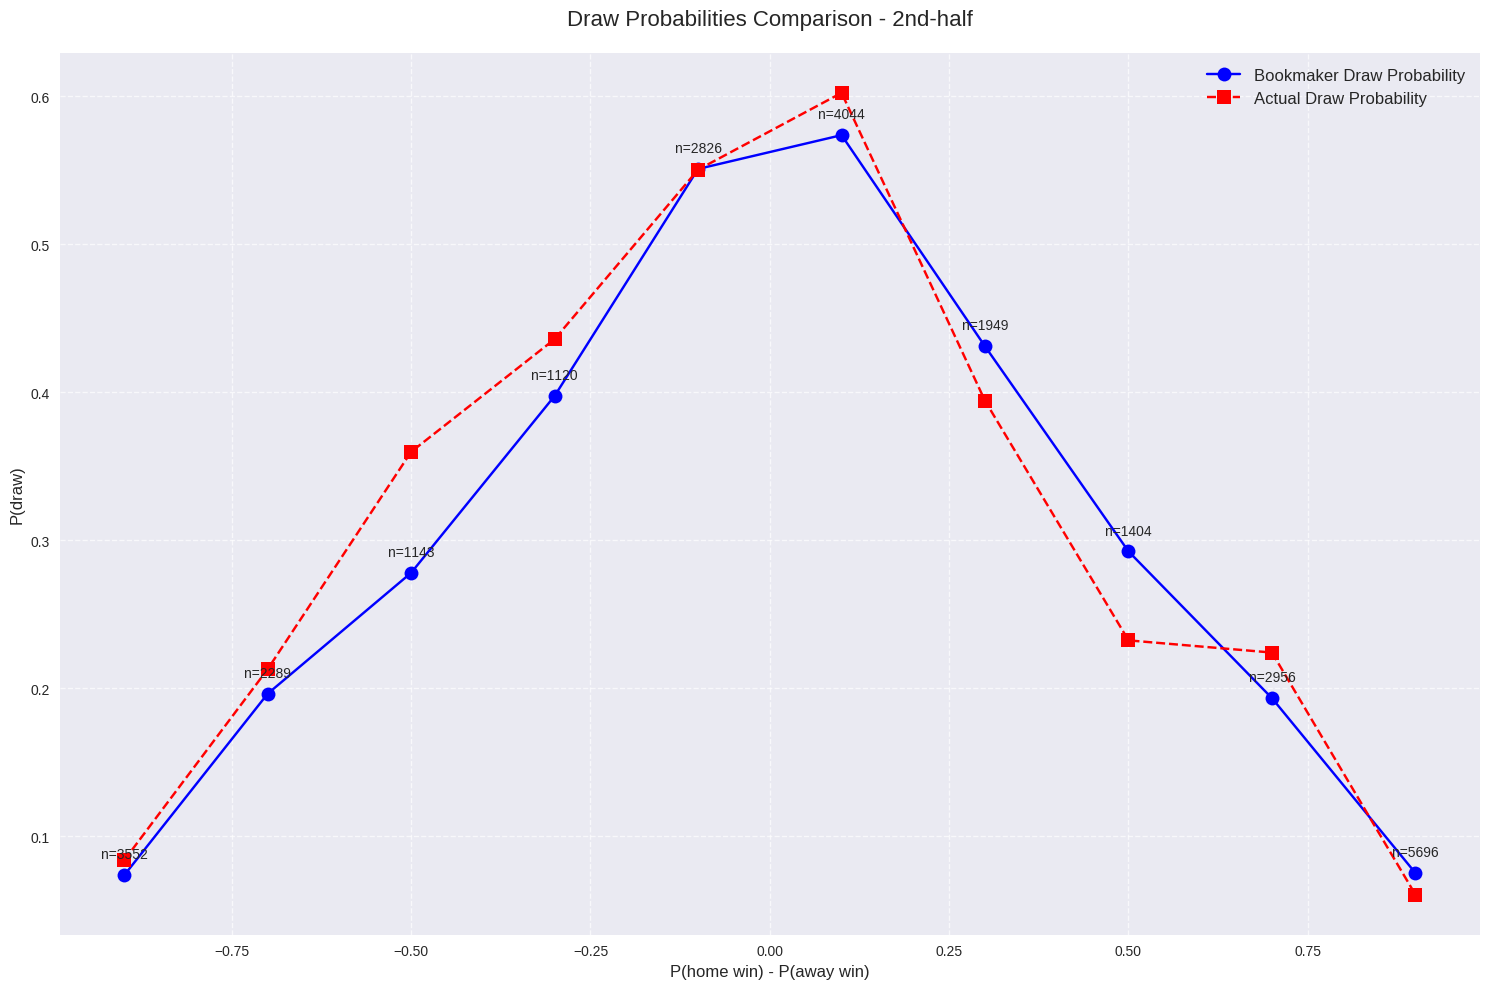

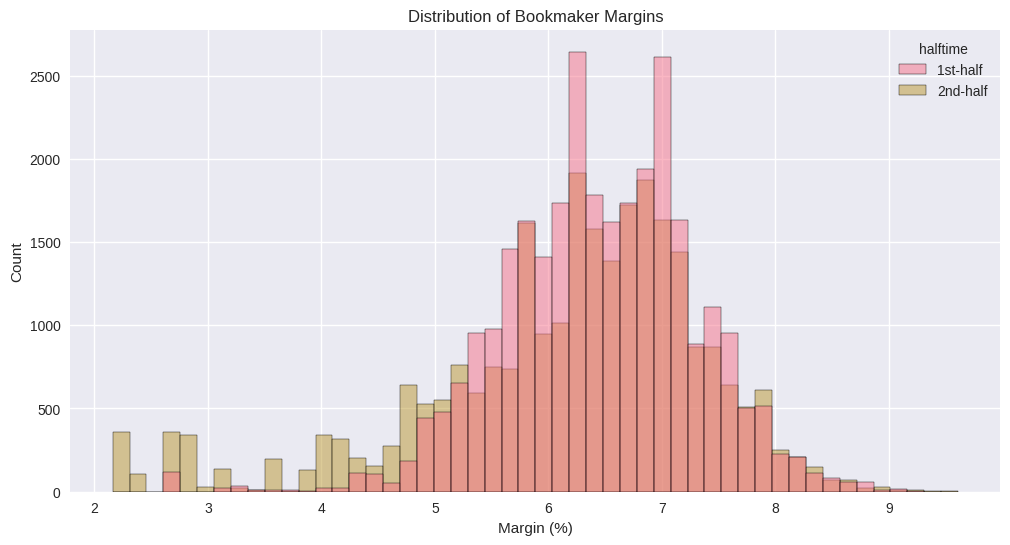

Draw Probability Analysis

Implied Draw Probability Statistics:
            count       mean        std       min        25%        50%        75%        max
halftime                                                                                     
1st-half  29148.0  24.942169   8.148981  1.908224  20.689119  26.615236  30.287682  51.400934
2nd-half  26979.0  28.157873  21.754415  1.908224  10.418795  21.846177  42.654028  94.444444


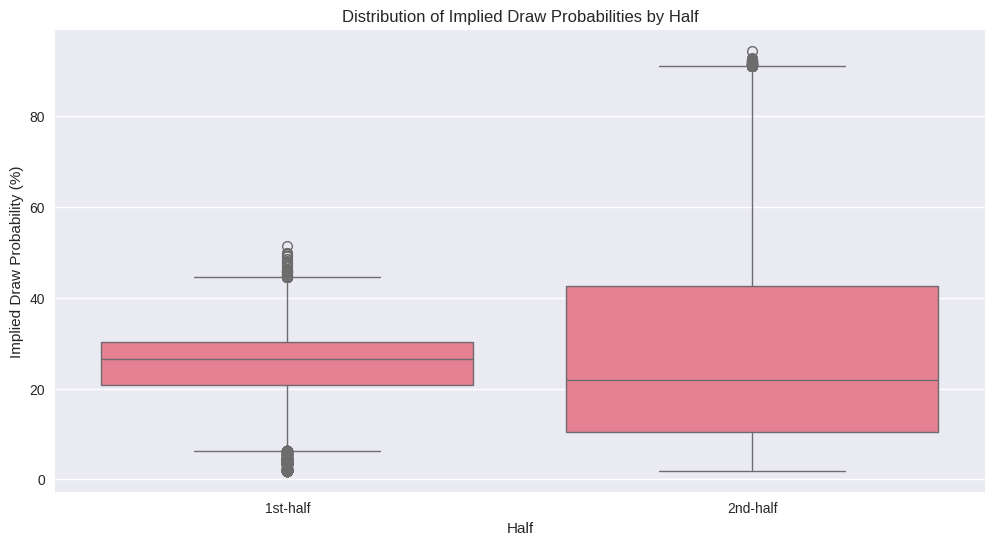

Probability Calibration Analysis

Calibration Statistics for 1st-half:


,bin,predicted_prob,actual_prob,count
0,0,0.081323,0.072351,2944
1,1,0.157778,0.128898,2886
2,2,0.204449,0.204631,2937
3,3,0.236752,0.269616,2893
4,4,0.256864,0.242905,2960
5,5,0.272783,0.303186,2919
6,6,0.287850,0.356021,2865
7,7,0.303549,0.338446,2934
8,8,0.325744,0.335978,2899
9,9,0.368872,0.364480,2911


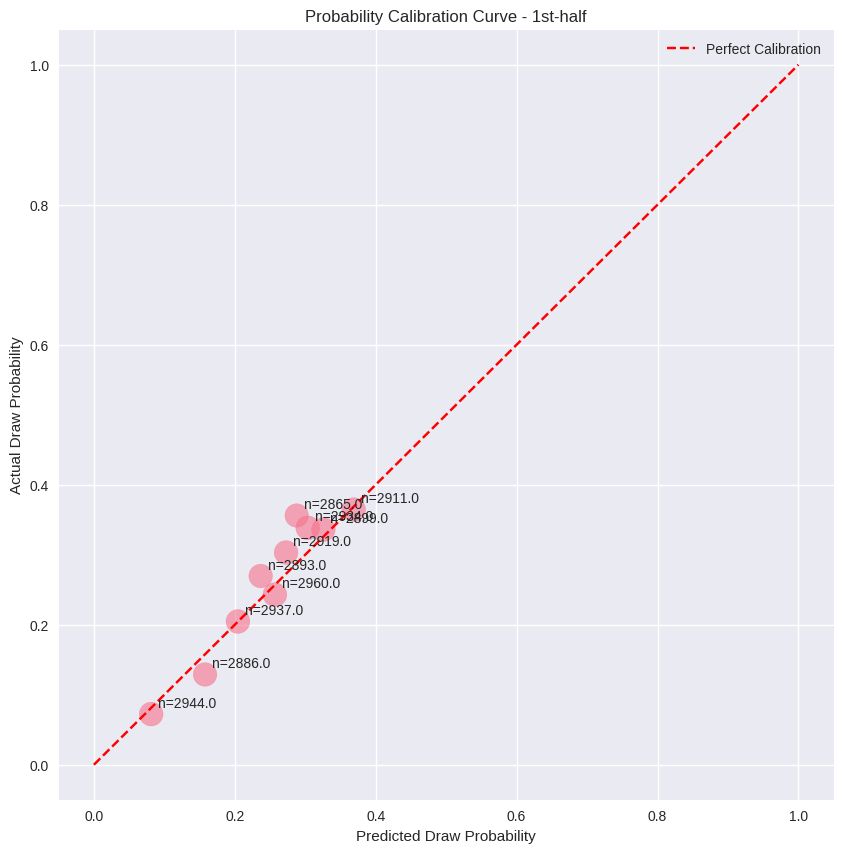


Calibration Statistics for 2nd-half:


,bin,predicted_prob,actual_prob,count
0,0,0.030384,0.011713,2732
1,1,0.060534,0.074934,2669
2,2,0.103133,0.083766,2698
3,3,0.150080,0.182689,2715
4,4,0.198846,0.225000,2680
5,5,0.252944,0.243343,2704
6,6,0.328860,0.341146,2688
7,7,0.427291,0.428677,2699
8,8,0.530068,0.532593,2700
9,9,0.735387,0.759465,2694


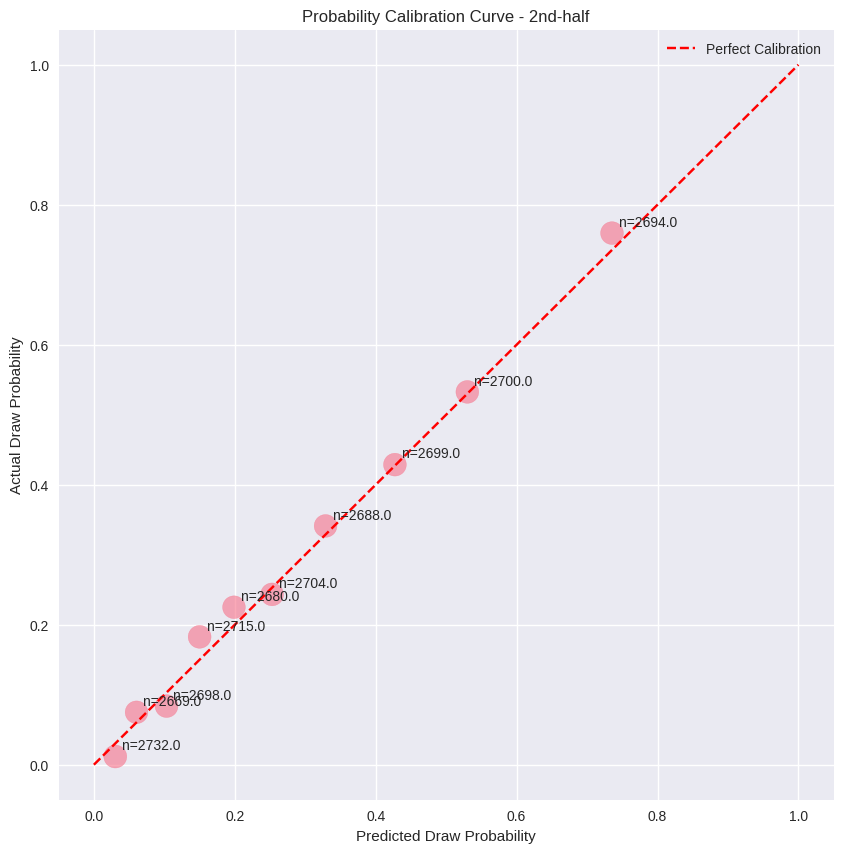

Market Efficiency Analysis

Average Probability Error by Half:
halftime
1st-half    0.365390
2nd-half    0.310248
Name: draw_prob_error, dtype: float64

Brier Score by Half:
halftime
1st-half    0.18482
2nd-half    0.15528
Name: brier_score, dtype: float64


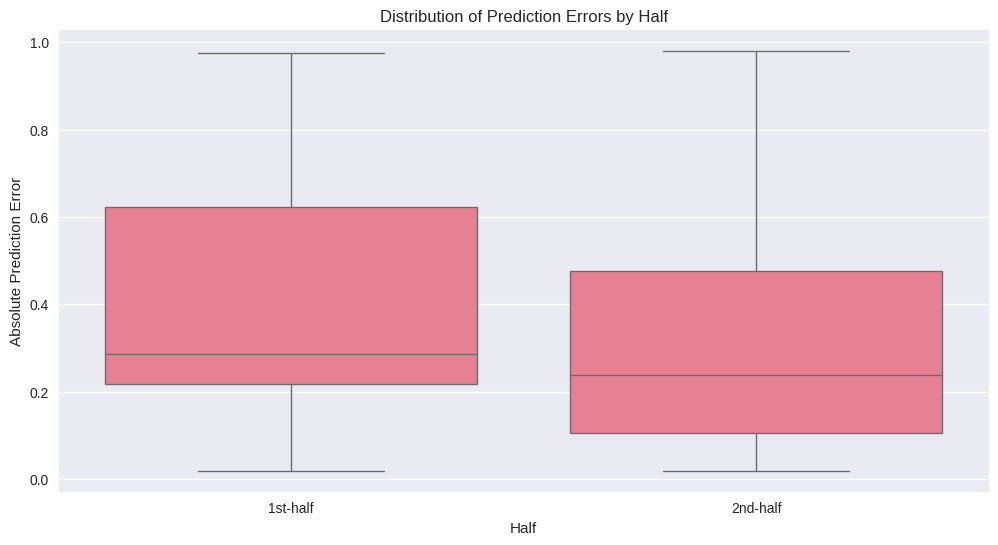

In [95]:
# Main execution cell
def run_analysis(df: pd.DataFrame):
    """
    Run all analyses in sequence.
    """
    # Original analysis
    results = analyze_odds_bias(df)

    # Additional analyses
    analyze_bookmaker_margin(df)
    analyze_draw_probabilities(df)
    analyze_probability_calibration(df)
    analyze_market_efficiency(df)

    return results

# Execute all analyses
results = run_analysis(df)

## Task 2

In [21]:
# Import Libraries and Set Up Environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, List
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [24]:
# Data Loading and Preprocessing
def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    """
    Load and preprocess the match data with additional cleaning steps.
    """
    # Load data
    df = pd.read_csv('match_data')

    # Convert datetime columns
    datetime_cols = ['current_time', 'half_start_datetime', 'match_start_datetime',
                    'latest_bookmaker_update']
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col])

    # Filter out suspended/stopped odds
    df = df[~(df['suspended'] | df['stopped'])]

    # Convert odds columns to numeric
    odds_columns = ['1', 'X', '2']
    df[odds_columns] = df[odds_columns].apply(pd.to_numeric, errors='coerce')

    # Extract goal information
    df['home_goals'] = df['final_score'].str.split('-').str[0].astype(int)
    df['away_goals'] = df['final_score'].str.split('-').str[1].astype(int)

    # Rename columns
    df = df.rename(columns={
        'Redcards - home': 'redcards_home',
        'Redcards - away': 'redcards_away'
    })

    # Display basic information
    print("Dataset Overview:")
    print("-" * 50)
    print(f"Total number of rows: {len(df)}")
    print(f"Number of unique matches: {df['fixture_id'].nunique()}")
    print("\nSample of the processed data:")
    display(df.head())

    return df


In [23]:
df = pd.read_csv('match_data')

list(df.columns)

['fixture_id',
 'halftime',
 'current_time',
 'half_start_datetime',
 'match_start_datetime',
 'minute',
 'second',
 'latest_bookmaker_update',
 'suspended',
 'stopped',
 '1',
 '2',
 'X',
 'name',
 'ticking',
 'Accurate Crosses - away',
 'Accurate Crosses - home',
 'Assists - away',
 'Assists - home',
 'Attacks - away',
 'Attacks - home',
 'Ball Possession % - away',
 'Ball Possession % - home',
 'Ball Safe - away',
 'Ball Safe - home',
 'Challenges - away',
 'Challenges - home',
 'Corners - away',
 'Corners - home',
 'Counter Attacks - away',
 'Counter Attacks - home',
 'Dangerous Attacks - away',
 'Dangerous Attacks - home',
 'Dribble Attempts - away',
 'Dribble Attempts - home',
 'Fouls - away',
 'Fouls - home',
 'Free Kicks - away',
 'Free Kicks - home',
 'Goal Attempts - away',
 'Goal Attempts - home',
 'Goal Kicks - away',
 'Goal Kicks - home',
 'Goals - away',
 'Goals - home',
 'Headers - away',
 'Headers - home',
 'Hit Woodwork - away',
 'Hit Woodwork - home',
 'Injuries - away

In [25]:
# Late Goals Analysis
def analyze_late_goals(df: pd.DataFrame, late_goal_threshold: int = 90) -> pd.DataFrame:
    """
    Identify matches with late goals that changed the outcome.
    """
    print(f"\nAnalyzing matches with goals after minute {late_goal_threshold}")
    print("=" * 80)

    match_stats = []

    for fixture_id in df['fixture_id'].unique():
        match_data = df[df['fixture_id'] == fixture_id].copy()

        # Get the last state before late goal threshold
        pre_late = match_data[match_data['minute'] <= late_goal_threshold].iloc[-1]
        final = match_data.iloc[-1]

        # Calculate scores and results
        pre_late_score = f"{pre_late['home_goals']}-{pre_late['away_goals']}"
        final_score = final['final_score']

        # Check if result changed
        pre_late_result = pre_late['current_state']
        final_result = final['result']

        if pre_late_result != final_result:
            match_stats.append({
                'fixture_id': fixture_id,
                'teams': final['name'],
                'pre_late_score': pre_late_score,
                'final_score': final_score,
                'pre_late_result': pre_late_result,
                'final_result': final_result,
                'pre_late_odds_home': pre_late['1'],
                'pre_late_odds_draw': pre_late['X'],
                'pre_late_odds_away': pre_late['2']
            })

    late_goals_df = pd.DataFrame(match_stats)

    if len(late_goals_df) > 0:
        print(f"\nFound {len(late_goals_df)} matches with result-changing late goals")
        print("\nSummary of matches with late goals:")
        display(late_goals_df)

        # Visualize late goals impact
        plt.figure(figsize=(12, 6))
        sns.countplot(data=late_goals_df, x='final_result')
        plt.title('Distribution of Final Results in Matches with Late Goals')
        plt.xlabel('Final Result')
        plt.ylabel('Count')
        plt.show()

        # Analyze odds impact
        print("\nOdds Impact Analysis:")
        for result in ['1', 'X', '2']:
            matches = late_goals_df[late_goals_df['final_result'] == result]
            if len(matches) > 0:
                print(f"\nMatches ending in {result}:")
                # Corrected line: Use consistent column name 'pre_late_odds_draw'
                odds_col = f"pre_late_odds_{result.lower()}".replace('1', 'home').replace('2', 'away').replace('x', 'draw')
                print(f"Average pre-late odds: {matches[odds_col].mean():.2f}")
                print(f"Median pre-late odds: {matches[odds_col].median():.2f}")

    return late_goals_df

In [26]:
# Red Cards Analysis
def analyze_red_cards(df: pd.DataFrame, early_threshold: int = 15) -> pd.DataFrame:
    """
    Analyze the impact of early red cards on match outcomes.
    """
    print(f"\nAnalyzing matches with red cards before minute {early_threshold}")
    print("=" * 80)

    red_card_stats = []

    for fixture_id in df['fixture_id'].unique():
        match_data = df[df['fixture_id'] == fixture_id].copy()
        early_data = match_data[match_data['minute'] <= early_threshold]

        if len(early_data) > 0:
            first_row = early_data.iloc[0]
            last_row = match_data.iloc[-1]

            home_reds = last_row['redcards_home'] - first_row['redcards_home']
            away_reds = last_row['redcards_away'] - first_row['redcards_away']

            if home_reds > 0 or away_reds > 0:
                red_card_stats.append({
                    'fixture_id': fixture_id,
                    'teams': last_row['name'],
                    'minute': early_data['minute'].min(),
                    'home_reds': home_reds,
                    'away_reds': away_reds,
                    'final_score': last_row['final_score'],
                    'result': last_row['result'],
                    'initial_odds_home': first_row['1'],
                    'initial_odds_draw': first_row['X'],
                    'initial_odds_away': first_row['2']
                })

    red_cards_df = pd.DataFrame(red_card_stats)

    if len(red_cards_df) > 0:
        print(f"\nFound {len(red_cards_df)} matches with early red cards")
        print("\nDetailed red card analysis:")
        display(red_cards_df)

        # Visualize red card impact
        plt.figure(figsize=(12, 6))
        red_cards_df['red_card_scenario'] = red_cards_df.apply(
            lambda x: f"Home: {int(x['home_reds'])}, Away: {int(x['away_reds'])}", axis=1
        )
        sns.countplot(data=red_cards_df, x='red_card_scenario', hue='result')
        plt.title('Match Results by Red Card Distribution')
        plt.xticks(rotation=45)
        plt.show()

        # Statistical analysis
        for team in ['home', 'away']:
            matches = red_cards_df[red_cards_df[f'{team}_reds'] > 0]
            if len(matches) > 0:
                print(f"\n{team.capitalize()} Team Red Card Impact:")
                print(f"Total matches: {len(matches)}")
                print(f"Win rate: {(matches['result'] == ('2' if team == 'home' else '1')).mean():.2%}")
                print(f"Draw rate: {(matches['result'] == 'X').mean():.2%}")
                print(f"Loss rate: {(matches['result'] == ('1' if team == 'home' else '2')).mean():.2%}")

        # Odds analysis
        print("\nOdds Analysis for Red Card Matches:")
        display(red_cards_df[['initial_odds_home', 'initial_odds_draw', 'initial_odds_away']].describe())

    return red_cards_df

In [32]:
# Combined Analysis Function
def analyze_combined_effects(df: pd.DataFrame, late_goals_df: pd.DataFrame, red_cards_df: pd.DataFrame):
    """
    Analyze matches affected by both late goals and early red cards.
    """
    print("\nAnalyzing Combined Effects of Late Goals and Red Cards")
    print("=" * 80)

    # Define combined_matches here to get fixture_ids present in both DataFrames
    combined_matches = late_goals_df.merge(red_cards_df, on='fixture_id', how='inner')

    if len(combined_matches) > 0:
        print(f"\nFound {len(combined_matches)} matches with both factors")

        combined_analysis = df[df['fixture_id'].isin(combined_matches['fixture_id'])].copy()

        # Detailed analysis table
        summary_data = []
        for fixture_id in combined_matches['fixture_id']:
            match_data = combined_analysis[combined_analysis['fixture_id'] == fixture_id]

            # Check if match_data is empty before accessing rows
            if not match_data.empty:
                first_row = match_data.iloc[0]
                last_row = match_data.iloc[-1]

                summary_data.append({
                    'Match': last_row['name'],
                    'Final Score': last_row['final_score'],
                    'Red Cards (H-A)': f"{last_row['redcards_home']}-{last_row['redcards_away']}",
                    'Initial Odds (H-D-A)': f"{first_row['1']:.2f}-{first_row['X']:.2f}-{first_row['2']:.2f}",
                    'Final Result': last_row['result']
                })
            else:
                print(f"Warning: No data found for fixture_id: {fixture_id}")
                # Handle the case where match_data is empty, e.g., skip or log

        combined_summary = pd.DataFrame(summary_data)
        display(combined_summary)

        # Visualize combined effects
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        combined_analysis.groupby('fixture_id')['1'].plot(alpha=0.3, legend=False)
        plt.title('Home Win Odds Movement\nin Combined Effect Matches')
        plt.xlabel('Time Index')
        plt.ylabel('Home Win Odds')

        plt.subplot(1, 2, 2)
        combined_analysis.groupby('fixture_id')['X'].plot(alpha=0.3, legend=False)
        plt.title('Draw Odds Movement\nin Combined Effect Matches')
        plt.xlabel('Time Index')
        plt.ylabel('Draw Odds')

        plt.tight_layout()
        plt.show()

In [28]:
# Main Execution and Results
def main():
    """
    Execute the complete analysis workflow.
    """
    # Load and preprocess data
    df = load_and_preprocess_data('match_data.csv')

    # Analyze late goals
    late_goals_df = analyze_late_goals(df)

    # Analyze red cards
    red_cards_df = analyze_red_cards(df)

    # Analyze combined effects
    analyze_combined_effects(df, late_goals_df, red_cards_df)

    # Create adjusted dataset for Task 1
    excluded_matches = pd.concat([
        late_goals_df['fixture_id'],
        red_cards_df['fixture_id']
    ]).unique()

    adjusted_df = df[~df['fixture_id'].isin(excluded_matches)].copy()

    print("\nAdjusted Dataset Statistics:")
    print("-" * 50)
    print(f"Original matches: {df['fixture_id'].nunique()}")
    print(f"Excluded matches: {len(excluded_matches)}")
    print(f"Remaining matches: {adjusted_df['fixture_id'].nunique()}")

    # Save adjusted dataset
    adjusted_df.to_csv('adjusted_match_data.csv', index=False)
    print("\nAdjusted dataset saved as 'adjusted_match_data.csv'")

    return {
        'original_data': df,
        'late_goals_analysis': late_goals_df,
        'red_cards_analysis': red_cards_df,
        'adjusted_data': adjusted_df
    }

Dataset Overview:
--------------------------------------------------
Total number of rows: 56127
Number of unique matches: 648

Sample of the processed data:


,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,suspended,stopped,1,2,X,name,ticking,Accurate Crosses - away,Accurate Crosses - home,Assists - away,Assists - home,Attacks - away,Attacks - home,Ball Possession % - away,Ball Possession % - home,Ball Safe - away,Ball Safe - home,Challenges - away,Challenges - home,Corners - away,Corners - home,Counter Attacks - away,Counter Attacks - home,Dangerous Attacks - away,Dangerous Attacks - home,Dribble Attempts - away,Dribble Attempts - home,Fouls - away,Fouls - home,Free Kicks - away,Free Kicks - home,Goal Attempts - away,Goal Attempts - home,Goal Kicks - away,Goal Kicks - home,Goals - away,Goals - home,Headers - away,Headers - home,Hit Woodwork - away,Hit Woodwork - home,Injuries - away,Injuries - home,Interceptions - away,Interceptions - home,Key Passes - away,Key Passes - home,Long Passes - away,Long Passes - home,Offsides - away,Offsides - home,Passes - away,Passes - home,Penalties - away,Penalties - home,redcards_away,redcards_home,Saves - away,Saves - home,Score Change - away,Score Change - home,Shots Blocked - away,Shots Blocked - home,Shots Insidebox - away,Shots Insidebox - home,Shots Off Target - away,Shots Off Target - home,Shots On Target - away,Shots On Target - home,Shots Outsidebox - away,Shots Outsidebox - home,Shots Total - away,Shots Total - home,Substitutions - away,Substitutions - home,Successful Dribbles - away,Successful Dribbles - home,Successful Headers - away,Successful Headers - home,Successful Interceptions - away,Successful Interceptions - home,Successful Passes - away,Successful Passes - home,Successful Passes Percentage - away,Successful Passes Percentage - home,Tackles - away,Tackles - home,Throwins - away,Throwins - home,Total Crosses - away,Total Crosses - home,Yellowcards - away,Yellowcards - home,Yellowred Cards - away,Yellowred Cards - home,current_state,final_score,result,home_goals,away_goals
0,19172016.0,1st-half,2024-08-09 18:11:36,2024-08-09 18:01:37,2024-08-09 18:01:37,9,59,2024-08-09 18:11:28,False,False,1.22,10.0,6.5,Galatasaray vs Hatayspor,True,0.0,0.0,NaN,NaN,2.0,18.0,28.0,72.0,9.0,7.0,1.0,1.0,0.0,0.0,NaN,NaN,0.0,9.0,1.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,24.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,NaN,NaN,1.0,1.0,14.0,55.0,58.0,91.0,3.0,1.0,3.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,X,2-1,1,2,1
1,19172016.0,1st-half,2024-08-09 18:27:30,2024-08-09 18:01:37,2024-08-09 18:01:37,25,53,2024-08-09 18:27:24,False,False,1.20,13.0,6.0,Galatasaray vs Hatayspor,True,0.0,1.0,NaN,NaN,12.0,40.0,24.0,76.0,9.0,7.0,2.0,2.0,1.0,4.0,NaN,NaN,5.0,29.0,3.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,2.0,2.0,0.0,2.0,NaN,NaN,1.0,1.0,38.0,116.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,5.0,0.0,0.0,1.0,3.0,NaN,NaN,2.0,2.0,20.0,101.0,52.0,87.0,8.0,5.0,6.0,11.0,1.0,12.0,0.0,0.0,0.0,0.0,X,2-1,1,2,1
2,19172016.0,1st-half,2024-08-09 18:28:25,2024-08-09 18:01:37,2024-08-09 18:01:37,26,48,2024-08-09 18:28:20,False,False,1.20,13.0,6.0,Galatasaray vs Hatayspor,True,0.0,1.0,NaN,NaN,12.0,40.0,21.0,79.0,9.0,7.0,2.0,2.0,1.0,4.0,NaN,NaN,5.0,29.0,3.0,6.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,2.0,2.0,0.0,2.0,NaN,NaN,1.0,1.0,40.0,145.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,5.0,0.0,0.0,1.0,3.0,NaN,NaN,2.0,2.0,20.0,128.0,50.0,88.0,10.0,5.0,6.0,11.0,1.0,13.0,0.0,0.0,0.0,0.0,X,2-1,1,2,1
3,19172016.0,1st-half,2024-08-09 18:29:32,2024-08-09 18:01:37,2024-08-09 18:01:37,27,55,2024-08-09 18:29:28,False,False,1.20,13.0,6.0,Galatasaray vs Hatayspor,True,0.0,1.0,NaN,NaN,12.0,42.0,22.0,78.0,9.0,7.0,2.0,2.0,1.0,4.0,NaN,NaN,5.0,32.0,3.0,6.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,2.0,3.0,0.0,2.0,NaN,NaN,1.0,1.0,45.0,153.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,


Analyzing matches with goals after minute 90

Found 32 matches with result-changing late goals

Summary of matches with late goals:


,fixture_id,teams,pre_late_score,final_score,pre_late_result,final_result,pre_late_odds_home,pre_late_odds_draw,pre_late_odds_away
0,19172018.0,Bodrumspor vs Gaziantep F.K.,0-1,0-1,X,2,7.00,1.10,41.00
1,19172027.0,Kayserispor vs Sivasspor,1-2,1-2,X,2,201.00,9.00,1.07
2,19155070.0,Genoa vs Inter,2-2,2-2,2,X,29.00,1.05,12.00
3,19172019.0,Göztepe vs Fenerbahçe,2-2,2-2,2,X,451.00,17.00,1.02
4,19154545.0,Borussia Mönchengladbach vs Bayer 04 Leverkusen,2-3,2-3,X,2,21.00,1.08,11.00
5,19135276.0,Villarreal vs Celta de Vigo,4-3,4-3,X,1,11.00,1.05,41.00
6,19134476.0,Everton vs AFC Bournemouth,2-3,2-3,X,2,23.00,1.02,23.00
7,19135293.0,Mallorca vs Villarreal,1-2,1-2,X,2,21.00,1.10,10.00
8,19155101.0,Genoa vs Roma,1-1,1-1,2,X,501.00,26.00,1.00
9,19172049.0,Antalyaspor vs Adana Demirspor,2-1,2-1,X,1,15.00,1.05,19.00


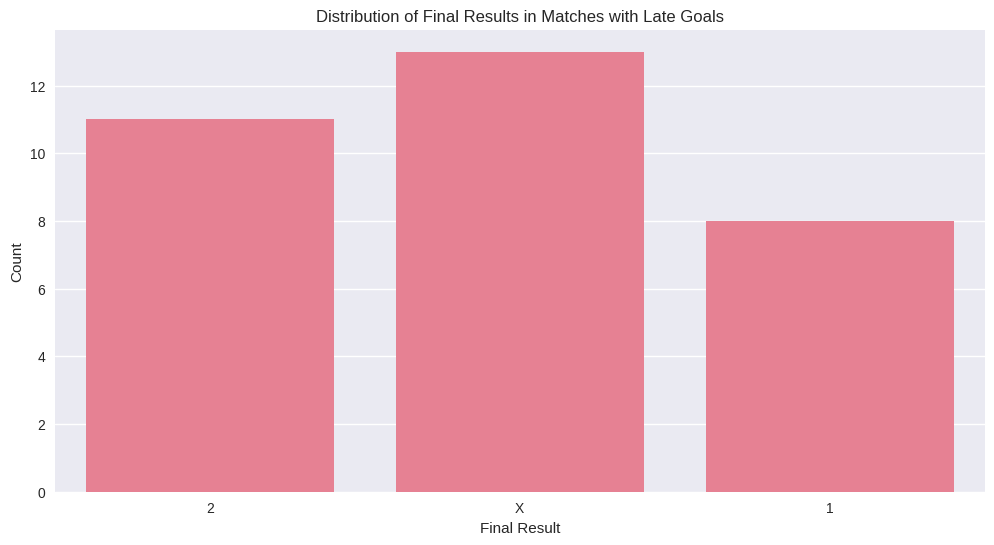


Odds Impact Analysis:

Matches ending in 1:
Average pre-late odds: 11.96
Median pre-late odds: 11.50

Matches ending in X:
Average pre-late odds: 16.16
Median pre-late odds: 17.00

Matches ending in 2:
Average pre-late odds: 13.96
Median pre-late odds: 10.00

Analyzing matches with red cards before minute 15

Found 88 matches with early red cards

Detailed red card analysis:


,fixture_id,teams,minute,home_reds,away_reds,final_score,result,initial_odds_home,initial_odds_draw,initial_odds_away
0,19172018.0,Bodrumspor vs Gaziantep F.K.,1,0.0,1.0,0-1,2,2.05,3.25,3.75
1,19134456.0,Everton vs Brighton & Hove Albion,1,1.0,0.0,0-3,2,3.10,3.40,2.30
2,19172027.0,Kayserispor vs Sivasspor,1,0.0,1.0,1-2,2,2.30,3.25,3.10
3,19155076.0,Parma vs Fiorentina,1,0.0,1.0,1-1,X,3.50,3.25,2.10
4,19139657.0,Reims vs LOSC Lille,0,1.0,0.0,0-2,2,2.87,3.25,2.50
...,...,...,...,...,...,...,...,...,...,...
83,19172115.0,Kasımpaşa vs Kayserispor,0,0.0,1.0,1-2,2,1.75,3.60,4.50
84,19172116.0,Hatayspor vs Gaziantep F.K.,0,0.0,1.0,3-1,1,2.20,3.40,3.10
85,19154631.0,FSV Mainz 05 vs Borussia Dortmund,2,0.0,1.0,3-1,1,4.00,3.60,1.90
86,19134536.0,Crystal Palace vs Fulham,1,1.0,0.0,0-2,2,3.25,3.25,2.25


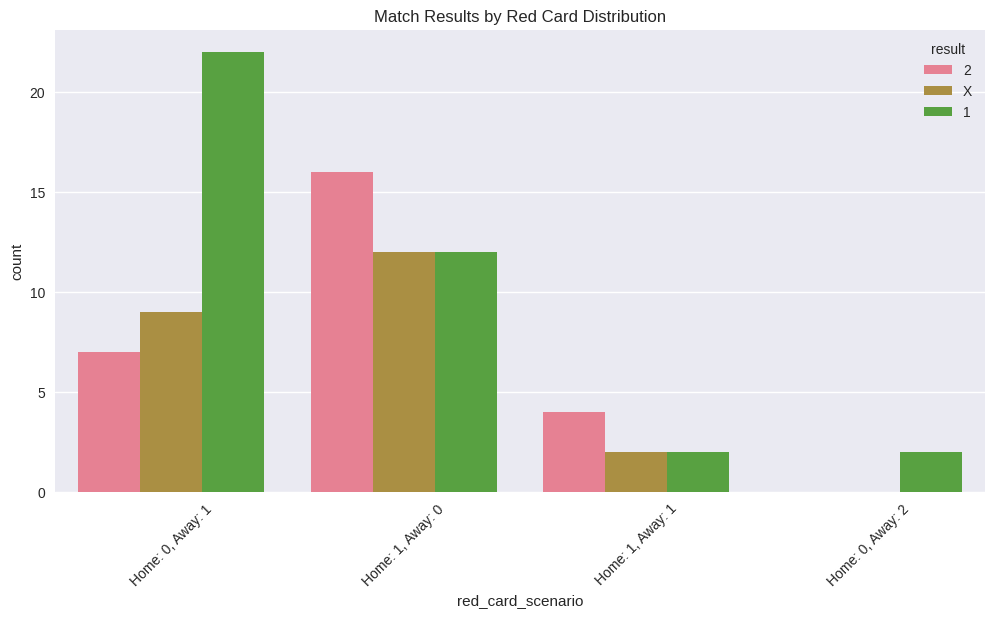


Home Team Red Card Impact:
Total matches: 48
Win rate: 41.67%
Draw rate: 29.17%
Loss rate: 29.17%

Away Team Red Card Impact:
Total matches: 48
Win rate: 54.17%
Draw rate: 22.92%
Loss rate: 22.92%

Odds Analysis for Red Card Matches:


,initial_odds_home,initial_odds_draw,initial_odds_away
count,88.000000,88.000000,88.000000
mean,2.408068,3.725114,3.884091
std,0.998305,0.845888,2.059198
min,1.200000,3.000000,1.400000
25%,1.830000,3.250000,2.590000
50%,2.200000,3.500000,3.250000
75%,2.750000,3.750000,4.372500
max,8.500000,7.500000,11.000000



Analyzing Combined Effects of Late Goals and Red Cards

Found 8 matches with both factors


,Match,Final Score,Red Cards (H-A),Initial Odds (H-D-A),Final Result
0,Bodrumspor vs Gaziantep F.K.,0-1,0.0-1.0,2.05-3.25-3.75,2
1,Kayserispor vs Sivasspor,1-2,0.0-1.0,2.30-3.25-3.10,2
2,Mallorca vs Villarreal,1-2,1.0-0.0,2.35-3.25-3.20,2
3,Trabzonspor vs Kayserispor,2-2,0.0-1.0,1.55-4.00-6.00,X
4,Lecce vs Parma,2-2,1.0-1.0,2.05-3.50-3.60,X
5,Manchester City vs Arsenal,2-2,0.0-1.0,1.80-3.50-5.00,X
6,Monaco vs Montpellier,2-1,0.0-1.0,1.28-6.00-9.00,1
7,Southampton vs Leicester City,2-3,1.0-0.0,2.20-3.60-3.25,2


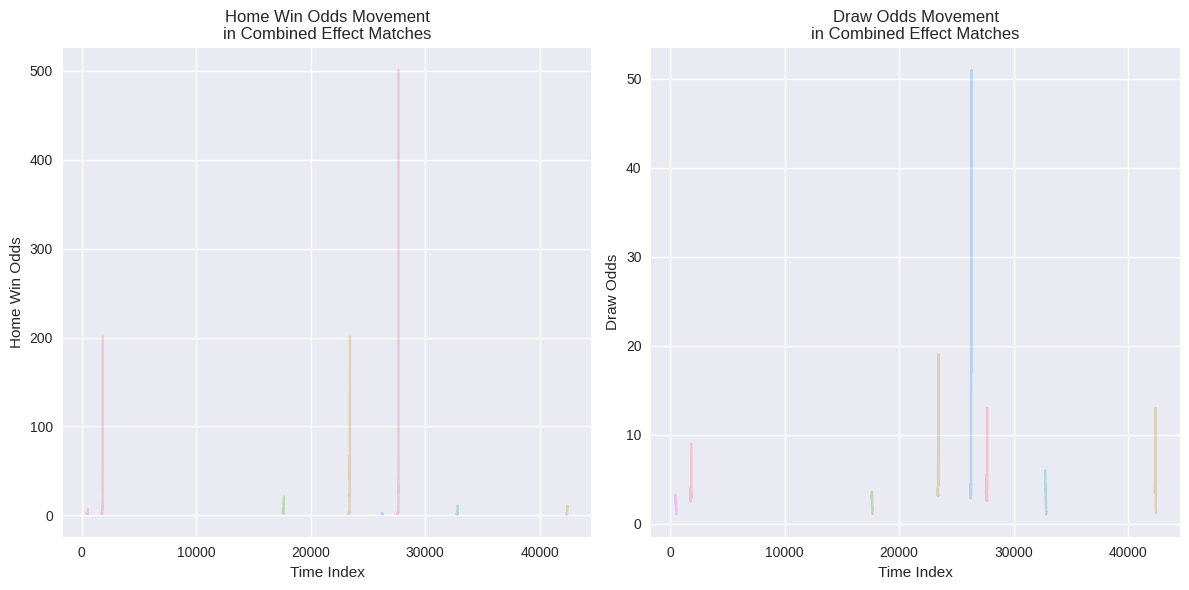


Adjusted Dataset Statistics:
--------------------------------------------------
Original matches: 648
Excluded matches: 112
Remaining matches: 536

Adjusted dataset saved as 'adjusted_match_data.csv'


In [33]:
# Execute analysis
results = main()

## Task 3

In [43]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [44]:
# Data Loading and Initial Processing
def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    """
    Load and preprocess the match data with feature engineering.
    """
    print("Loading and preprocessing data...")
    df = pd.read_csv('match_data')

    # Filter out suspended/stopped odds
    df = df[~(df['suspended'] | df['stopped'])]

    # Calculate implied probabilities from odds
    df['implied_prob_home'] = 1 / df['1']
    df['implied_prob_draw'] = 1 / df['X']
    df['implied_prob_away'] = 1 / df['2']

    # Normalize probabilities
    prob_sum = df['implied_prob_home'] + df['implied_prob_draw'] + df['implied_prob_away']
    df['implied_prob_home_norm'] = df['implied_prob_home'] / prob_sum
    df['implied_prob_draw_norm'] = df['implied_prob_draw'] / prob_sum
    df['implied_prob_away_norm'] = df['implied_prob_away'] / prob_sum

    print("\nDataset Overview:")
    print(f"Total rows: {len(df)}")
    print(f"Unique matches: {df['fixture_id'].nunique()}")

    return df

In [61]:
# Feature Engineering
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create new features from match statistics.
    """
    print("\nEngineering features...")

    # Game state features
    df['goals_difference'] = df['Goals - home'] - df['Goals - away']
    df['total_goals'] = df['Goals - home'] + df['Goals - away']

    # Possession and attacking features
    df['possession_ratio'] = df['Ball Possession % - home'] / df['Ball Possession % - away']
    df['attack_ratio'] = (df['Dangerous Attacks - home'] + df['Counter Attacks - home']) / \
                        (df['Dangerous Attacks - away'] + df['Counter Attacks - away'] + 1)

    # Shooting efficiency
    df['shots_on_target_ratio_home'] = df['Shots On Target - home'] / (df['Shots Total - home'] + 1)
    df['shots_on_target_ratio_away'] = df['Shots On Target - away'] / (df['Shots Total - away'] + 1)

    # Passing efficiency
    df['passing_accuracy_diff'] = df['Successful Passes Percentage - home'] - \
                                df['Successful Passes Percentage - away']

    # Defensive performance
    df['defensive_actions_home'] = df['Interceptions - home'] + df['Tackles - home']
    df['defensive_actions_away'] = df['Interceptions - away'] + df['Tackles - away']
    df['defensive_ratio'] = df['defensive_actions_home'] / (df['defensive_actions_away'] + 1)

    # Pressure indicators
    df['attacking_pressure_home'] = df['Shots On Target - home'] + df['Corners - home'] * 0.5
    df['attacking_pressure_away'] = df['Shots On Target - away'] + df['Corners - away'] * 0.5
    df['pressure_ratio'] = df['attacking_pressure_home'] / (df['attacking_pressure_away'] + 1)

    # Cards and fouls
    df['discipline_score_home'] = df['Yellowcards - home'] + 3 * df['Redcards - home']
    df['discipline_score_away'] = df['Yellowcards - away'] + 3 * df['Redcards - away']
    df['discipline_ratio'] = df['discipline_score_home'] / (df['discipline_score_away'] + 1)

    # Time-based features
    df['time_remaining'] = np.where(df['halftime'] == '1st-half',
                                  90 - df['minute'],
                                  45 - df['minute'])

    # Momentum features
    df['recent_attack_momentum'] = df.groupby('fixture_id')['Dangerous Attacks - home'].diff(3)
    df['recent_shot_momentum'] = df.groupby('fixture_id')['Shots On Target - home'].diff(3)

    print("\nEngineered features created. Sample of new features:")

    # Get the original columns.
    original_columns = df.columns.tolist()

    # Get the new features by finding columns that weren't originally in the DataFrame.
    # Calculate the number of new features by subtracting the original number of columns from the current number.
    num_new_features = len(df.columns) - len(original_columns)

    # If there are new features, then display their descriptive statistics.
    # Otherwise, print a message indicating that no new features were created.
    if num_new_features > 0:
        new_features = df.columns[len(df.columns) - num_new_features:].tolist()
        display(df[new_features].describe())
    else:
        print("No new features were created.")

    return df

In [62]:
# Feature Selection and Preparation
def prepare_features(df: pd.DataFrame) -> tuple:
    """
    Prepare features and target variables for modeling.
    """
    print("\nPreparing features for modeling...")

    # Select relevant features
    feature_columns = [
        'goals_difference', 'total_goals',
        'possession_ratio', 'attack_ratio',
        'shots_on_target_ratio_home', 'shots_on_target_ratio_away',
        'passing_accuracy_diff', 'defensive_ratio',
        'pressure_ratio', 'discipline_ratio',
        'time_remaining',
        'implied_prob_home_norm', 'implied_prob_draw_norm', 'implied_prob_away_norm',
        'Dangerous Attacks - home', 'Dangerous Attacks - away',
        'Shots On Target - home', 'Shots On Target - away',
        'Corners - home', 'Corners - away',
        'Ball Possession % - home', 'Ball Possession % - away',
        'defensive_actions_home', 'defensive_actions_away',
        'recent_attack_momentum', 'recent_shot_momentum'
    ]

    # Remove rows with missing values
    df_clean = df.dropna(subset=feature_columns + ['result'])

    X = df_clean[feature_columns]
    y = df_clean['result']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    print("\nFeature set summary:")
    print(f"Number of features: {len(feature_columns)}")
    print(f"Number of samples: {len(X_scaled)}")

    return X_scaled, y, feature_columns

In [63]:
# Model Training and Evaluation
def train_and_evaluate_model(X: pd.DataFrame, y: pd.Series, feature_names: list) -> tuple:
    """
    Train decision tree model and evaluate its performance.
    """
    print("\nTraining and evaluating model...")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Grid search for best parameters
    param_grid = {
        'max_depth': [3, 4, 5, 6],
        'min_samples_leaf': [50, 100, 150],
        'min_samples_split': [100, 150, 200]
    }

    dt = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    print("\nBest parameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_

    # Evaluate model
    print("\nModel Performance:")
    y_pred = best_model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Feature importance analysis
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Visualize feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()
    plt.show()

    return best_model, feature_importance

In [69]:
# Market Efficiency Analysis
def analyze_market_efficiency(df: pd.DataFrame, model: DecisionTreeClassifier,
                            X: pd.DataFrame, feature_names: list):
    """
    Analyze market efficiency by comparing model predictions with implied probabilities.
    """
    print("\nAnalyzing Market Efficiency...")

    # Get model probabilities
    model_probs = model.predict_proba(X)

    # Create efficiency analysis DataFrame using only the rows where the model has predictions
    # We align the probabilities with the original DataFrame using the index of X
    efficiency_df = pd.DataFrame({
        'Model_Prob_1': model_probs[:, np.where(model.classes_ == '1')[0][0]],
        'Model_Prob_X': model_probs[:, np.where(model.classes_ == 'X')[0][0]],
        'Model_Prob_2': model_probs[:, np.where(model.classes_ == '2')[0][0]],
    }, index=X.index) # Set the index to match X

    # Merge with the market probabilities from the original DataFrame using the index
    efficiency_df = efficiency_df.merge(
        df[['implied_prob_home_norm', 'implied_prob_draw_norm', 'implied_prob_away_norm']],
        left_index=True, right_index=True,
        suffixes=('_model', '_market') # Add suffixes to the overlapping columns
    )
    #Rename the market columns to their original names
    efficiency_df = efficiency_df.rename(columns={
        'implied_prob_home_norm': 'Market_Prob_1',
        'implied_prob_draw_norm': 'Market_Prob_X',
        'implied_prob_away_norm': 'Market_Prob_2'
    })

    # Calculate probability differences
    outcomes = {'1': 'Home', 'X': 'Draw', '2': 'Away'}
    for model_key, market_name in outcomes.items():
        efficiency_df[f'Prob_Diff_{market_name}'] = (
            efficiency_df[f'Model_Prob_{model_key}'] -
            efficiency_df[f'Market_Prob_{model_key}']
        )

    # Analyze significant differences
    threshold = 0.1  # 10% difference threshold
    significant_diffs = efficiency_df[
        (abs(efficiency_df['Prob_Diff_Home']) > threshold) |
        (abs(efficiency_df['Prob_Diff_Draw']) > threshold) |
        (abs(efficiency_df['Prob_Diff_Away']) > threshold)
    ]

    # Print analysis results
    print("\nMarket Efficiency Analysis Results:")
    print(f"Total predictions analyzed: {len(efficiency_df)}")
    print(f"Predictions with significant differences: {len(significant_diffs)}")
    print(f"Percentage of significant differences: {(len(significant_diffs)/len(efficiency_df))*100:.2f}%")

    # Visualize probability differences
    plt.figure(figsize=(15, 10))

    # Probability difference distributions
    for i, outcome in enumerate(['Home', 'Draw', 'Away']):
        plt.subplot(2, 2, i+1)
        sns.histplot(data=efficiency_df[f'Prob_Diff_{outcome}'], bins=50)
        plt.title(f'{outcome} Probability Differences\n(Model - Market)')
        plt.xlabel('Probability Difference')
        plt.ylabel('Count')

    # Scatter plot of model vs market probabilities
    plt.subplot(2, 2, 4)
    plt.scatter(efficiency_df['Market_Prob_1'], efficiency_df['Model_Prob_1'],
                alpha=0.5, label='Home')
    plt.scatter(efficiency_df['Market_Prob_X'], efficiency_df['Model_Prob_X'],
                alpha=0.5, label='Draw')
    plt.scatter(efficiency_df['Market_Prob_2'], efficiency_df['Model_Prob_2'],
                alpha=0.5, label='Away')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('Market Probability')
    plt.ylabel('Model Probability')
    plt.title('Model vs Market Probabilities')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return efficiency_df, significant_diffs

In [65]:
# Decision Rule Analysis
def analyze_decision_rules(model: DecisionTreeClassifier, feature_names: list, X: pd.DataFrame, y: pd.Series):
    """
    Analyze and visualize decision rules from the tree.
    """
    print("\nAnalyzing Decision Rules...")

    # Visualize decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(model, feature_names=feature_names, class_names=['1', 'X', '2'],
             filled=True, rounded=True, fontsize=10)
    plt.title("Decision Tree Visualization")
    plt.show()

    # Extract and print important decision rules
    print("\nKey Decision Rules:")
    rules = export_text(model, feature_names=feature_names)
    print(rules)

    # Analyze feature thresholds
    feature_thresholds = {}
    n_nodes = model.tree_.node_count
    feature = model.tree_.feature
    threshold = model.tree_.threshold

    for node in range(n_nodes):
        if feature[node] != -2:  # not a leaf node
            feat_name = feature_names[feature[node]]
            if feat_name not in feature_thresholds:
                feature_thresholds[feat_name] = []
            feature_thresholds[feat_name].append(threshold[node])

    print("\nKey Feature Thresholds:")
    for feat, thresholds in feature_thresholds.items():
        print(f"\n{feat}:")
        print(f"  Average threshold: {np.mean(thresholds):.3f}")
        print(f"  Threshold range: [{min(thresholds):.3f}, {max(thresholds):.3f}]")

In [66]:
# Insights Generation
def generate_insights(model: DecisionTreeClassifier, feature_importance: pd.DataFrame,
                     efficiency_df: pd.DataFrame, significant_diffs: pd.DataFrame):
    """
    Generate comprehensive insights from the analysis.
    """
    print("\nKey Insights from Analysis:")
    print("=" * 50)

    # Feature importance insights
    print("\n1. Key Predictive Factors:")
    for _, row in feature_importance.head(5).iterrows():
        print(f"- {row['feature']}: {row['importance']:.3f}")

    # Market efficiency insights
    print("\n2. Market Efficiency Analysis:")
    print(f"- {len(significant_diffs)} instances ({(len(significant_diffs)/len(efficiency_df))*100:.1f}%) "
          f"show significant differences between model and market probabilities")

    # Calculate average probability differences
    avg_diffs = {
        'Home': efficiency_df['Prob_Diff_Home'].mean(),
        'Draw': efficiency_df['Prob_Diff_Draw'].mean(),
        'Away': efficiency_df['Prob_Diff_Away'].mean()
    }

    print("\n3. Average Probability Differences (Model - Market):")
    for outcome, diff in avg_diffs.items():
        print(f"- {outcome}: {diff:.3f}")

    # Model performance insights
    print("\n4. Decision Tree Model Insights:")
    print(f"- Primary split feature: {feature_importance.iloc[0]['feature']}")
    print(f"- Model complexity: {model.get_depth()} levels deep")
    print(f"- Total decision paths: {model.get_n_leaves()}")

In [67]:
# Main Execution
def main():
    """
    Execute the complete analysis workflow.
    """
    # Load and process data
    df = load_and_preprocess_data('match_data.csv')

    # Engineer features
    df = engineer_features(df)

    # Prepare features
    X, y, feature_names = prepare_features(df)

    # Train and evaluate model
    model, feature_importance = train_and_evaluate_model(X, y, feature_names)

    # Analyze market efficiency
    efficiency_df, significant_diffs = analyze_market_efficiency(df, model, X, feature_names)

    # Analyze decision rules
    analyze_decision_rules(model, feature_names, X, y)

    # Generate insights
    generate_insights(model, feature_importance, efficiency_df, significant_diffs)

    return {
        'model': model,
        'feature_importance': feature_importance,
        'efficiency_analysis': efficiency_df,
        'significant_differences': significant_diffs
    }


Loading and preprocessing data...

Dataset Overview:
Total rows: 56127
Unique matches: 648

Engineering features...

Engineered features created. Sample of new features:
No new features were created.

Preparing features for modeling...

Feature set summary:
Number of features: 26
Number of samples: 18912

Training and evaluating model...

Best parameters: {'max_depth': 6, 'min_samples_leaf': 50, 'min_samples_split': 100}

Model Performance:

Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.82      0.80      1527
           2       0.89      0.63      0.74      1154
           X       0.60      0.73      0.66      1102

    accuracy                           0.74      3783
   macro avg       0.75      0.73      0.73      3783
weighted avg       0.76      0.74      0.74      3783



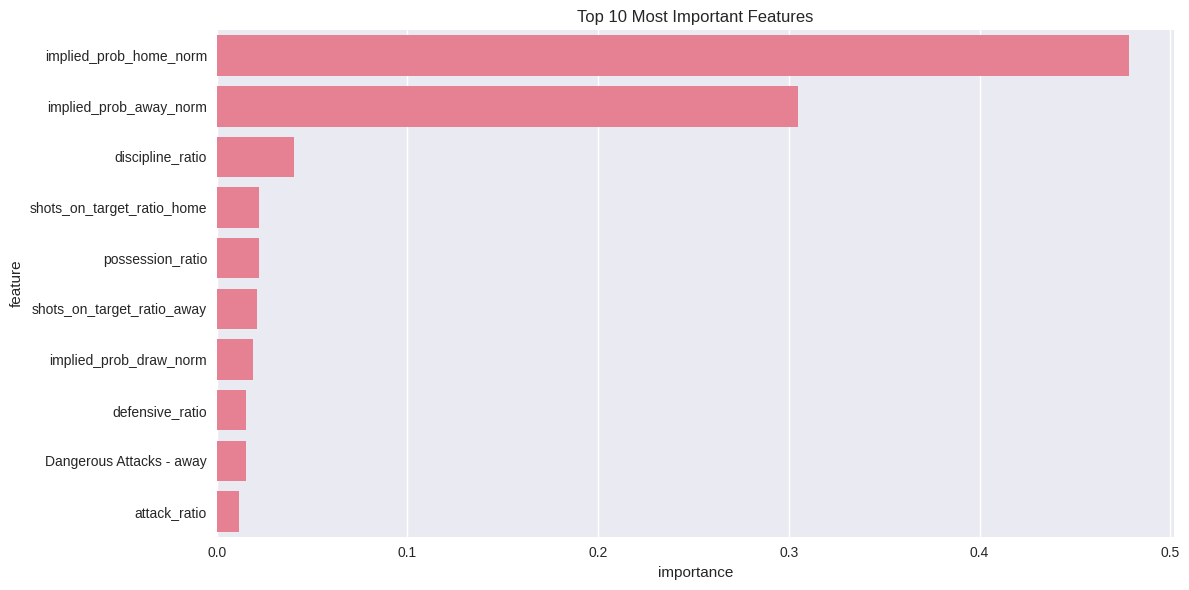


Analyzing Market Efficiency...

Market Efficiency Analysis Results:
Total predictions analyzed: 16719
Predictions with significant differences: 15716
Percentage of significant differences: 94.00%


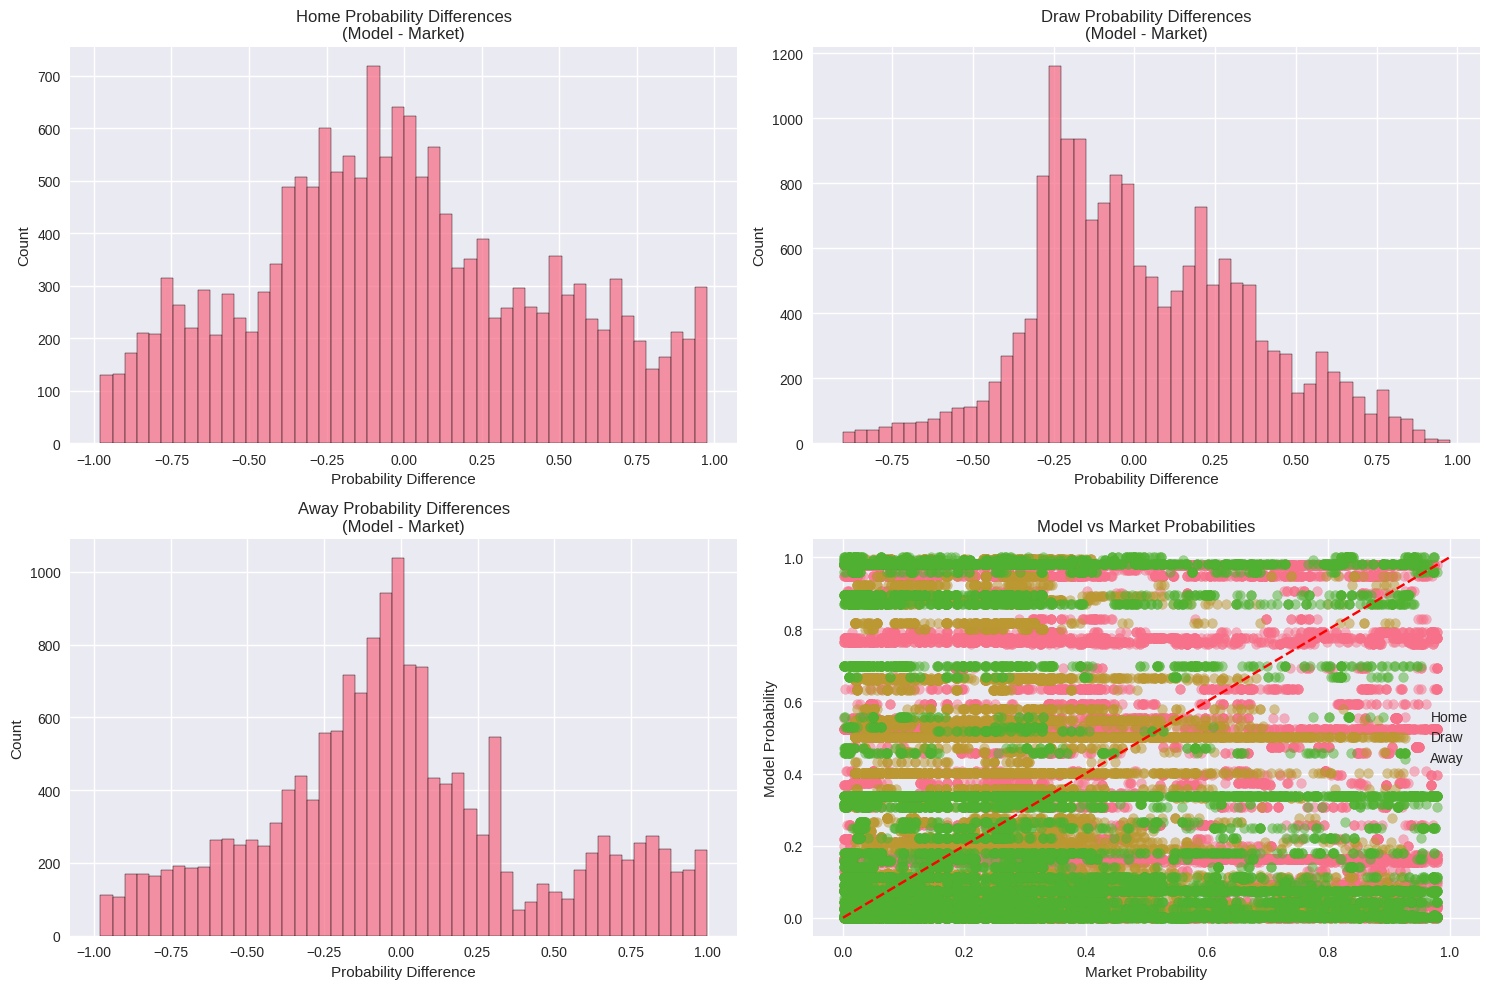


Analyzing Decision Rules...


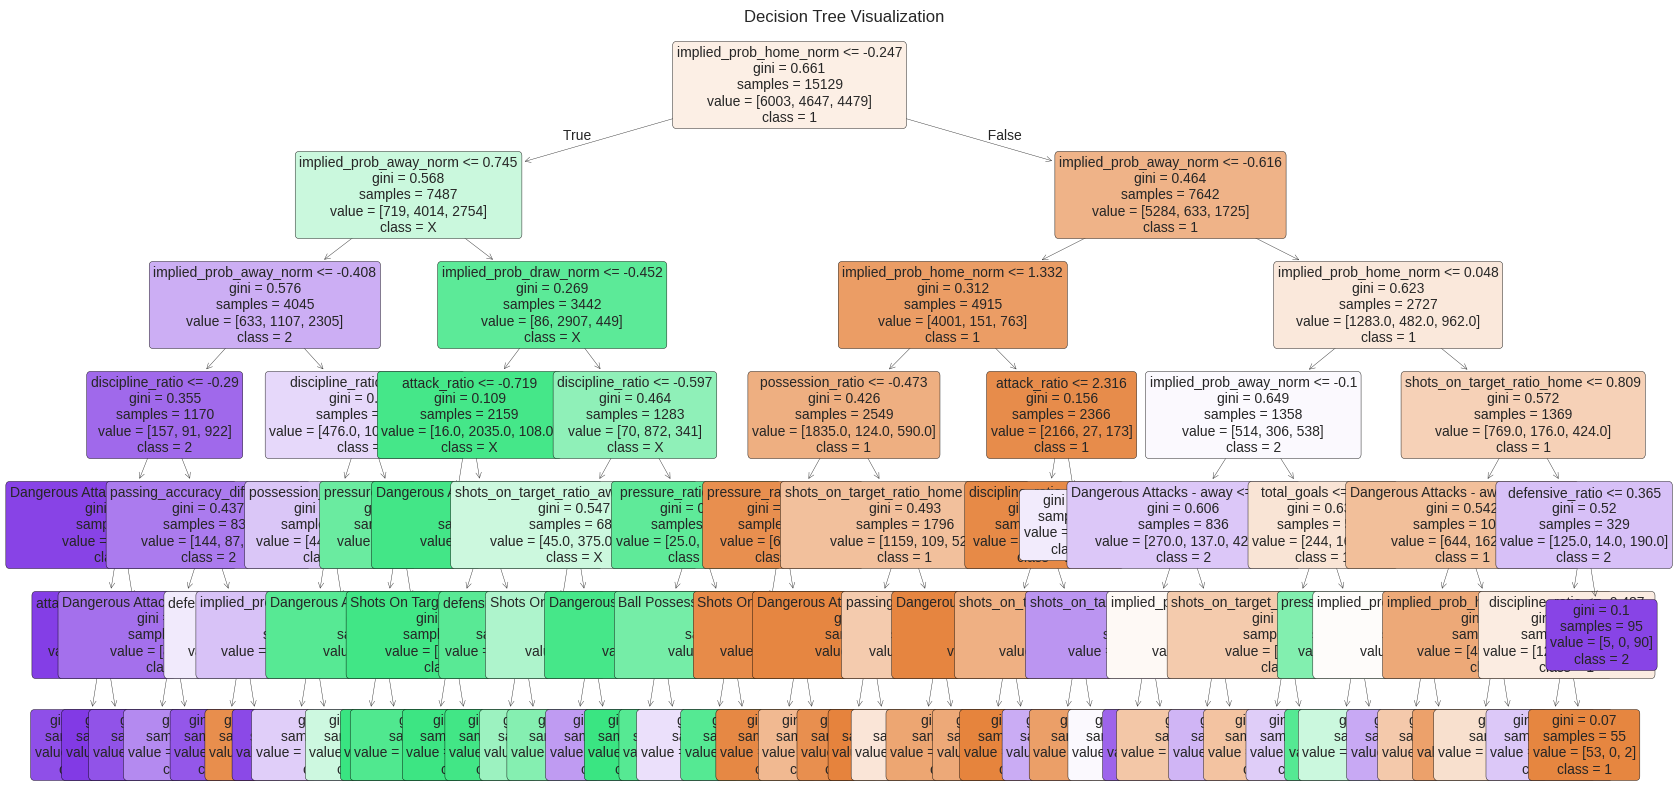


Key Decision Rules:
|--- implied_prob_home_norm <= -0.25
|   |--- implied_prob_away_norm <= 0.74
|   |   |--- implied_prob_away_norm <= -0.41
|   |   |   |--- discipline_ratio <= -0.29
|   |   |   |   |--- Dangerous Attacks - home <= 1.89
|   |   |   |   |   |--- attack_ratio <= -0.35
|   |   |   |   |   |   |--- class: X
|   |   |   |   |   |--- attack_ratio >  -0.35
|   |   |   |   |   |   |--- class: X
|   |   |   |   |--- Dangerous Attacks - home >  1.89
|   |   |   |   |   |--- class: X
|   |   |   |--- discipline_ratio >  -0.29
|   |   |   |   |--- passing_accuracy_diff <= 1.18
|   |   |   |   |   |--- Dangerous Attacks - home <= 0.48
|   |   |   |   |   |   |--- class: X
|   |   |   |   |   |--- Dangerous Attacks - home >  0.48
|   |   |   |   |   |   |--- class: X
|   |   |   |   |--- passing_accuracy_diff >  1.18
|   |   |   |   |   |--- defensive_ratio <= -0.37
|   |   |   |   |   |   |--- class: X
|   |   |   |   |   |--- defensive_ratio >  -0.37
|   |   |   |   |   |   |--

In [70]:
# Execute complete analysis
results = main()